In [1]:
import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector

    
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

In [3]:
data = pd.read_csv("ner_dataset.csv", encoding='latin1')

In [4]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [5]:
data.shape

(1048575, 4)

In [6]:
data = data.fillna(method='ffill')

In [7]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [8]:
data.tail()

,Sentence #,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [9]:
data.columns

Index(['Sentence #', 'Word', 'POS', 'Tag'], dtype='object')

In [10]:
#data[data['Word']=='at']

In [11]:
listOfSeries = [pd.Series(['Sentence: 47960','Dr','NNP','B-prov'],index=data.columns),
                pd.Series(['Sentence: 47960','Gregory','NNP','I-prov'],index=data.columns),
                pd.Series(['Sentence: 47960','M','NNP','I-prov'],index=data.columns),
                pd.Series(['Sentence: 47960','Cowan','NNP','I-prov'],index=data.columns),
                pd.Series(['Sentence: 47960','is','VBZ','O'],index=data.columns),
                pd.Series(['Sentence: 47960','an','DT','O'],index=data.columns),
                pd.Series(['Sentence: 47960','Immunologist','NN','B-spec'],index=data.columns),
                pd.Series(['Sentence: 47960','at ','IN','O'],index=data.columns),
                pd.Series(['Sentence: 47960','Fortis','NNP','B-org'],index=data.columns),
                pd.Series(['Sentence: 47960','Hospital','NNP','I-org'],index=data.columns),
                pd.Series(['Sentence: 47961','Dr','NNP','B-prov'],index=data.columns),
                pd.Series(['Sentence: 47961','Debra','NNP','I-prov'],index=data.columns),
                pd.Series(['Sentence: 47961','H','NNP','I-prov'],index=data.columns),
                pd.Series(['Sentence: 47961','Mescher','NNP','I-prov'],index=data.columns),
                pd.Series(['Sentence: 47961','is','VBZ','O'],index=data.columns),
                pd.Series(['Sentence: 47961','an ','DT','O'],index=data.columns),
                pd.Series(['Sentence: 47961','Internist','NN','B-spec'],index=data.columns),
                pd.Series(['Sentence: 47962','Jordan','NNP','B-prov'],index=data.columns),
                pd.Series(['Sentence: 47962','A','NNP','I-prov'],index=data.columns),
                pd.Series(['Sentence: 47962','Sennett','NNP','I-prov'],index=data.columns),
                pd.Series(['Sentence: 47962','is','VBZ','O'],index=data.columns),
                pd.Series(['Sentence: 47962','an','DT','O'],index=data.columns),
                pd.Series(['Sentence: 47962','Endocrinologist','NN','B-spec'],index=data.columns)
                ]

In [12]:
# Pass a list of series to the append() to add multiple rows
data = data.append(listOfSeries , ignore_index=True)

In [13]:
data.tail(25)

,Sentence #,Word,POS,Tag
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O
1048575,Sentence: 47960,Dr,NNP,B-prov
1048576,Sentence: 47960,Gregory,NNP,I-prov
1048577,Sentence: 47960,M,NNP,I-prov
1048578,Sentence: 47960,Cowan,NNP,I-prov
1048579,Sentence: 47960,is,VBZ,O
1048580,Sentence: 47960,an,DT,O
1048581,Sentence: 47960,Immunologist,NN,B-spec
1048582,Sentence: 47960,at,IN,O


In [14]:
data['Sentence #'].unique()

array(['Sentence: 1', 'Sentence: 2', 'Sentence: 3', ...,
       'Sentence: 47960', 'Sentence: 47961', 'Sentence: 47962'],
      dtype=object)

In [15]:
print(data.groupby(['Sentence #']))
print("Number of sentences: ", len(data.groupby(['Sentence #'])))

Number of sentences:  47962


In [16]:
words = list(set(data['Word'].values))
n_words = len(words)
print("Number of unique words in the dataset: ", n_words)
print("Number of total words in the dataset: ", len(list(data['Word'].values)))

Number of unique words in the dataset:  35189
Number of total words in the dataset:  1048598


In [17]:
tags = list(set(data['Tag'].values))
n_tags = len(tags)
print(tags)
print("Number of tags in the dataset: ", n_tags)

['B-prov', 'B-tim', 'B-gpe', 'I-prov', 'I-nat', 'I-per', 'I-eve', 'I-art', 'O', 'I-tim', 'B-per', 'B-org', 'I-org', 'I-geo', 'B-spec', 'B-art', 'B-geo', 'I-gpe', 'B-nat', 'B-eve']
Number of tags in the dataset:  20


In [18]:
agg_func = lambda s:[(w,p,t) for w,p,t in zip(s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].values.tolist())]

In [19]:
for i in zip(data["Word"].values.tolist(), data["POS"].values.tolist(), data["Tag"].values.tolist()):
    print(i)    
    if i[0] == 'marched':
        assert False

('Thousands', 'NNS', 'O')
('of', 'IN', 'O')
('demonstrators', 'NNS', 'O')
('have', 'VBP', 'O')
('marched', 'VBN', 'O')


AssertionError: 

In [20]:
class SentenceGetter(object):
    """
    Class to get sentence in format : [(Token, PartOfSpeech,Tag),()]
    """
    def __init__(self,data):
        """
        data : pandas dataframe
        """
        self.n_sent = 1
        self.data = data
        self.empty = False
        
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
        print(len(self.sentences))
        print(self.sentences[-1])
        
    def get_next(self):
        """Return One Sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
    

In [21]:
getter = SentenceGetter(data)

47962
[('The', 'DT', 'O'), ('United', 'NNP', 'B-org'), ('Nations', 'NNP', 'I-org'), ('is', 'VBZ', 'O'), ('praising', 'VBG', 'O'), ('the', 'DT', 'O'), ('use', 'NN', 'O'), ('of', 'IN', 'O'), ('military', 'JJ', 'O'), ('helicopters', 'NNS', 'O'), ('to', 'TO', 'O'), ('drop', 'VB', 'O'), ('food', 'NN', 'O'), ('and', 'CC', 'O'), ('rescue', 'NN', 'O'), ('survivors', 'NNS', 'O'), ('in', 'IN', 'O'), ('tsunami-ravaged', 'JJ', 'B-tim'), ('Indonesia', 'NNP', 'I-tim'), (',', ',', 'O'), ('saying', 'VBG', 'O'), ('the', 'DT', 'O'), ('aircraft', 'NN', 'O'), ('are', 'VBP', 'O'), ('"', '``', 'O'), ('worth', 'IN', 'O'), ('their', 'PRP$', 'O'), ('weight', 'NN', 'O'), ('in', 'IN', 'O'), ('gold', 'NN', 'O'), ('.', '.', 'O'), ('"', '``', 'O')]


In [22]:
print(type(getter))

<class '__main__.SentenceGetter'>


In [23]:
sent = getter.get_next()

In [24]:
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [25]:
# Get all the sentences
sentences = getter.sentences
print(len(sentences))

47962


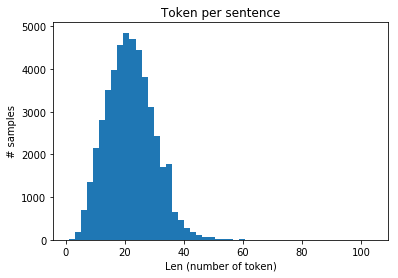

In [26]:
# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [27]:
# Vocabulary Key:word --> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w:i+2 for i,w in enumerate(words)}

In [28]:
word2idx['UNK'] = 1 # Unknown words
word2idx['PAD'] = 0 # Padding

In [29]:
print(word2idx['of'])
print(word2idx['through'])
print(word2idx['George'])
print(word2idx['Endocrinologist'])
print(word2idx['andy'])

20683
450
8473
14164


KeyError: 'andy'

In [30]:
# Vocabulary Key:token_index  --> Value:word
idx2word = {i:w for w,i in word2idx.items()}

In [31]:
print(idx2word[0])
print(idx2word[1])
print(idx2word[2])

PAD
UNK
Choe


In [32]:
# Vocabulary Key:Label/Tag --> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i,t in enumerate(tags)}
tag2idx["PAD"] = 0 

In [33]:
# Vocabulary Key:tag_index --> Value:Label/Tag
idx2tag = {i:w for w,i in tag2idx.items()}

In [34]:
print(tag2idx)

{'B-prov': 1, 'B-tim': 2, 'B-gpe': 3, 'I-prov': 4, 'I-nat': 5, 'I-per': 6, 'I-eve': 7, 'I-art': 8, 'O': 9, 'I-tim': 10, 'B-per': 11, 'B-org': 12, 'I-org': 13, 'I-geo': 14, 'B-spec': 15, 'B-art': 16, 'B-geo': 17, 'I-gpe': 18, 'B-nat': 19, 'B-eve': 20, 'PAD': 0}


In [35]:
print(idx2tag)

{1: 'B-prov', 2: 'B-tim', 3: 'B-gpe', 4: 'I-prov', 5: 'I-nat', 6: 'I-per', 7: 'I-eve', 8: 'I-art', 9: 'O', 10: 'I-tim', 11: 'B-per', 12: 'B-org', 13: 'I-org', 14: 'I-geo', 15: 'B-spec', 16: 'B-art', 17: 'B-geo', 18: 'I-gpe', 19: 'B-nat', 20: 'B-eve', 0: 'PAD'}


In [36]:
print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))

The word Obama is identified by the index: 32899


In [37]:
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))

The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 17


In [38]:
print("The labels B-prov(which defines Providers) is identified by the index: {}".format(tag2idx["B-prov"]))

The labels B-prov(which defines Providers) is identified by the index: 1


In [39]:
from keras.preprocessing.sequence import pad_sequences

In [40]:
# Convert each sentence from list of tokens to list of word index
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [41]:
print(len(X))
print(len(sentences))

47962
47962


In [42]:
# Padding each sentence to have the same length
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding='post', value=word2idx["PAD"])

In [43]:
# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same length
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

In [44]:
from keras.utils import to_categorical

In [45]:
# One Hot encode
y = [to_categorical(y=i, num_classes=n_tags+1) for i in y] # n_tags+1(PAD)

In [46]:
print(y[0][0])
print(len(y[0][0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
21


In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

In [48]:
print(X_train.shape)
print(X_test.shape)
print(X_train.shape[0] + X_test.shape[0])
print(np.array(y_train).shape)
print(np.array(y_test).shape)
print(np.array(y_train).shape[0] + np.array(y_test).shape[0])

(43165, 75)
(4797, 75)
47962
(43165, 75, 21)
(4797, 75, 21)
47962


In [49]:
w0 = ' '.join([w[0] for w in sentences[0]])
print('Raw Sample: ')
print(w0)
print(len(w0))
print('\n')
print('After processing, sample:')
print(X[0])
print(len(X[0]))
print('\n')
for i in X[0]:
    print(i, idx2word[i])
print('\n')

Raw Sample: 
Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
145


After processing, sample:
[14079 20683 13185 15970 27375   450 12404 34505  3948  6403 15605 25463
 27935 25827 33855  6403 12709 20683  8071 29745  2166  1962 20412  3903
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
75


14079 Thousands
20683 of
13185 demonstrators
15970 have
27375 marched
450 through
12404 London
34505 to
3948 protest
6403 the
15605 war
25463 in
27935 Iraq
25827 and
33855 demand
6403 the
12709 withdrawal
20683 of
8071 British
29745 troops
2166 from
1962 that
20412 country
3903 .
0 PAD
0 PAD
0 PAD
0 PAD
0 PAD
0 PAD
0 PAD
0 PAD
0 PAD
0 PAD
0 PAD

In [65]:
w2 = ' '.join([w[2] for w in sentences[0]])
ws2 = [w[2] for w in sentences[0]]
print('Raw Label: ')
print(w2)
print(ws2)
print(len(ws2))
print(type(ws2))
print('\n')
print('After processing, labels:')
print(len(y[0]))
for i in range(len(ws2)):
    print(ws2[i],y[0][i])
    
print(y[0])


Raw Label: 
O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
24
<class 'list'>


After processing, labels:
75
O [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
O [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
O [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
O [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
O [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
O [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
B-geo [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
O [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
O [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
O [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
O [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
O [0.

In [52]:
# Install extra-dependencies
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

In [53]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)  
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

/home/ikscare/anaconda3/envs/py36/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/home/ikscare/anaconda3/envs/py36/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            703820    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 21)            1554      
Total params: 738,824
Trainable params: 738,824
Non-trainable params: 0
_________________________________________________________________


In [66]:
out

<tf.Tensor 'crf_1/cond/Merge:0' shape=(?, ?, 21) dtype=float32>

Note: Accuracy isn't the best metric to choose for evaluating this type of task because most of the time it will correctly predict 'O' or 'PAD' without identifing the important Tags, which are the ones we are interested in. So after training for some epochs, we can monitor the precision, recall and f1-score for each of the Tags.

In [54]:
history = model.fit(X_train, np.array(y_train), batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=0.1, verbose=2)

Train on 38848 samples, validate on 4317 samples
Epoch 1/5
 - 167s - loss: 9.5634 - crf_viterbi_accuracy: 0.9067 - val_loss: 9.4503 - val_crf_viterbi_accuracy: 0.9468
Epoch 2/5
 - 164s - loss: 9.3456 - crf_viterbi_accuracy: 0.9574 - val_loss: 9.3973 - val_crf_viterbi_accuracy: 0.9609
Epoch 3/5
 - 162s - loss: 9.3129 - crf_viterbi_accuracy: 0.9667 - val_loss: 9.3829 - val_crf_viterbi_accuracy: 0.9649
Epoch 4/5
 - 161s - loss: 9.3013 - crf_viterbi_accuracy: 0.9700 - val_loss: 9.3782 - val_crf_viterbi_accuracy: 0.9654
Epoch 5/5
 - 161s - loss: 9.2954 - crf_viterbi_accuracy: 0.9719 - val_loss: 9.3746 - val_crf_viterbi_accuracy: 0.9670


In [55]:
# Eval
pred_cat = model.predict(X_test)
pred = np.argmax(pred_cat, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [56]:
from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_test_true_tag = [[idx2tag[i] for i in row] for row in y_test_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_test_true_tag)
print(report)

/home/ikscare/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        40
       B-eve       0.00      0.00      0.00        29
       B-geo       0.82      0.90      0.86      3712
       B-gpe       0.97      0.92      0.94      1571
       B-nat       0.00      0.00      0.00        22
       B-org       0.77      0.68      0.72      2037
       B-per       0.84      0.79      0.81      1741
       B-tim       0.91      0.87      0.89      2066
       I-art       0.00      0.00      0.00        28
       I-eve       0.00      0.00      0.00        20
       I-geo       0.74      0.80      0.77       715
       I-gpe       0.89      0.53      0.67        15
       I-nat       0.00      0.00      0.00         5
       I-org       0.76      0.75      0.75      1731
       I-per       0.83      0.89      0.86      1805
       I-tim       0.81      0.71      0.76       644
           O       0.99      0.99      0.99     88835
         PAD       1.00    

In [57]:
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 1536 of 4797 (Test Set)
Word           ||True ||Pred
European       : B-org B-org
Union          : I-org I-org
foreign        : O     O
ministers      : O     O
are            : O     O
meeting        : O     O
in             : O     O
Brussels       : B-geo B-geo
to             : O     O
discuss        : O     O
support        : O     O
for            : O     O
an             : O     O
emerging       : O     O
Palestinian    : B-gpe B-gpe
unity          : O     O
government     : O     O
that           : O     O
could          : O     O
replace        : O     O
the            : O     O
current        : O     O
Hamas-led      : O     O
one            : O     O
.              : O     O


In [58]:
!pip install ipywidgets

    100% |████████████████████████████████| 112kB 291kB/s ta 0:00:01
    100% |████████████████████████████████| 2.2MB 365kB/s ta 0:00:01


In [ ]:
!jupyter nbextension enable --py widgetsnbextension

In [59]:
from ipywidgets import interact_manual
from ipywidgets import widgets

In [60]:
import re
import string

# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In [61]:
def get_prediction(sentence):
    test_sentence = tokenize(sentence) # Tokenization
    # Preprocessing
    x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=word2idx["PAD"], maxlen=MAX_LEN)
    # Evaluation
    p = model.predict(np.array([x_test_sent[0]]))
    p = np.argmax(p, axis=-1)
    # Visualization
    print("{:15}||{}".format("Word", "Prediction"))
    print(30 * "=")
    for w, pred in zip(test_sentence, p[0]):
        print("{:15}: {:5}".format(w, idx2tag[pred]))

In [62]:
interact_manual(get_prediction, sentence=widgets.Textarea(placeholder='Type your sentence here'))

interactive(children=(Textarea(value='', description='sentence', placeholder='Type your sentence here'), Butto…

<function __main__.get_prediction(sentence)>

In [63]:
get_prediction("Obama was the president of USA.")

Word           ||Prediction
Obama          : B-per
was            : O    
the            : O    
president      : O    
of             : O    
USA            : B-org
.              : O    


In [ ]:
get_prediction("The 1906 San Francisco earthquake was the biggest earthquake that has ever hit San Francisco on April 18, 1906")

In [ ]:
get_prediction("Next Monday is Christmas!")

In [ ]:
get_prediction("al Qaeda is a terrorist organization")

In [ ]:
get_prediction("President Nasser presided over the audience")

In [ ]:
get_prediction("John Smith works at the United Nations every Saturday")

In [ ]:
get_prediction("Andy Garcia works at the United Nations every Saturday")

In [64]:
get_prediction("Gregory M Cowan is an Immunologist at Fortis Hospital")

Word           ||Prediction
Gregory        : B-per
M              : I-per
Cowan          : I-per
is             : O    
an             : O    
Immunologist   : O    
at             : O    
Fortis         : B-geo
Hospital       : I-geo


In [ ]:
get_prediction("Debra H Mescher is an Internist")

In [ ]:
str = ("Colonoscopy Sigmoidoscopy Large Bowel Polyps Diverticulitis Crohn Gastritis Enteroscopy Colon Endoscope "
"Patient Name :  Pamela Woodard "
"DOB : 11/09/1996 " 
"Date : 21/10/18 "
"Order orders Appointment Schedule Requesting Provider Physician Prescriber Surgery Clearance Medical clearance Supply Supplies "
"Christian Chu  MD "
"WeServeEveryone Clinic")

get_prediction(str)